In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2024-01-03 21:56:06.036288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2012'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(start_year), int(end_month), int(end_day))
t = (int(end_year)-int(start_year)+1)*(numOfDays(date1, date2)+1)

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)


#### change t multiplicative factor based on hourly vs 15min data
cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
elif int(start_year)<int(end_year):
   # y=1
    for i in range(int(start_year),int(end_year)+1,1):
       # if y==1:
            for m in range(int(start_month),int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+str(i)+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
             #   y=y+1
                month=[]
            
      #  else:
        #    for m in range(1,int(end_month)+1,1):
        #        if m<10:
         #           month = str(m).zfill(2)
        #        else:
        #            month = str(m)    
        #        for d in range(1,calendar.monthrange(i, m)[1]+1,1):
        #            if d<10:
        #                day = str(d).zfill(2)
         #           else:
         #               day = str(d)  
         #           dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
        #            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
         #           list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

8778


In [7]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010400.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010500.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010600.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010700.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010800.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010900.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011000.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011100.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011200.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011300.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011400.nc
14
/prj/

/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
123
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
124
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
125
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060600.nc
126
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060700.nc
127
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060800.nc
128
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060900.nc
129
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061000.nc
130
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061100.nc
131
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061200.nc
132
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061300.nc
133
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061400.nc
134
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061500.nc
135
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061600.nc
136
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_

244
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110500.nc
245
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
246
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110700.nc
247
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110800.nc
248
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110900.nc
249
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111000.nc
250
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111100.nc
251
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111200.nc
252
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111300.nc
253
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111400.nc
254
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111500.nc
255
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111600.nc
256
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111700.nc
257
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111800.nc
258
/prj/nflics/hist_cores/2010/06/11/Hist_cores

/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160700.nc
367
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160800.nc
368
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160900.nc
369
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161000.nc
370
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161100.nc
371
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161200.nc
372
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161300.nc
373
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161400.nc
374
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161500.nc
375
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161600.nc
376
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161700.nc
377
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161800.nc
378
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161900.nc
379
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006162000.nc
380
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210800.nc
488
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210900.nc
489
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211000.nc
490
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211100.nc
491
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211200.nc
492
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211300.nc
493
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211400.nc
494
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211500.nc
495
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211600.nc
496
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211700.nc
497
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211800.nc
498
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211900.nc
499
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212000.nc
500
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212100.nc
501
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260900.nc
609
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261000.nc
610
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261100.nc
611
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261200.nc
612
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261300.nc
613
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261400.nc
614
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261500.nc
615
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261600.nc
616
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261700.nc
617
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261800.nc
618
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261900.nc
619
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262000.nc
620
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262100.nc
621
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262200.nc
622
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_

729
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011000.nc
730
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011100.nc
731
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011200.nc
732
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011300.nc
733
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011400.nc
734
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011500.nc
735
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011600.nc
736
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011700.nc
737
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011800.nc
738
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011900.nc
739
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012000.nc
740
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012100.nc
741
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012200.nc
742
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012300.nc
743
/prj/nflics/hist_cores/2010/07/02/Hist_cores

/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061100.nc
851
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061200.nc
852
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061300.nc
853
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061400.nc
854
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061500.nc
855
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061600.nc
856
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061700.nc
857
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061800.nc
858
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061900.nc
859
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062000.nc
860
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062100.nc
861
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062200.nc
862
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062300.nc
863
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070000.nc
864
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_

971
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111200.nc
972
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111300.nc
973
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111400.nc
974
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111500.nc
975
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111600.nc
976
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111700.nc
977
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111800.nc
978
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111900.nc
979
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112000.nc
980
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112100.nc
981
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112200.nc
982
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112300.nc
983
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120000.nc
984
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120100.nc
985
/prj/nflics/hist_cores/2010/07/12/Hist_cores

1092
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161300.nc
1093
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161400.nc
1094
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161500.nc
1095
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161600.nc
1096
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161700.nc
1097
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161800.nc
1098
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161900.nc
1099
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162000.nc
1100
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162100.nc
1101
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162200.nc
1102
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162300.nc
1103
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170000.nc
1104
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170100.nc
1105
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170200.nc
1106
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211200.nc
1212
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211300.nc
1213
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211400.nc
1214
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211500.nc
1215
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211600.nc
1216
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211700.nc
1217
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211800.nc
1218
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211900.nc
1219
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212000.nc
1220
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212100.nc
1221
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212200.nc
1222
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212300.nc
1223
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220000.nc
1224
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220100.nc
1225
/prj/nflics/hist_cores/2010/07/22/

/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261100.nc
1331
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261200.nc
1332
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261300.nc
1333
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261400.nc
1334
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261500.nc
1335
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261600.nc
1336
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261700.nc
1337
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261800.nc
1338
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261900.nc
1339
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262000.nc
1340
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262100.nc
1341
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262200.nc
1342
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262300.nc
1343
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270000.nc
1344
/prj/nflics/hist_cores/2010/07/27/

/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311000.nc
1450
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311100.nc
1451
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311200.nc
1452
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311300.nc
1453
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311400.nc
1454
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311500.nc
1455
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311600.nc
1456
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311700.nc
1457
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311800.nc
1458
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311900.nc
1459
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312000.nc
1460
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312100.nc
1461
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312200.nc
1462
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312300.nc
1463
/prj/nflics/hist_cores/2010/08/01/

/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050900.nc
1569
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051000.nc
1570
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051100.nc
1571
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051200.nc
1572
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051300.nc
1573
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051400.nc
1574
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051500.nc
1575
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051600.nc
1576
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051700.nc
1577
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051800.nc
1578
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051900.nc
1579
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052000.nc
1580
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052100.nc
1581
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052200.nc
1582
/prj/nflics/hist_cores/2010/08/05/

/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100800.nc
1688
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100900.nc
1689
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101000.nc
1690
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101100.nc
1691
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101200.nc
1692
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101300.nc
1693
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101400.nc
1694
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101500.nc
1695
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101600.nc
1696
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101700.nc
1697
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101800.nc
1698
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101900.nc
1699
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102000.nc
1700
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102100.nc
1701
/prj/nflics/hist_cores/2010/08/10/

1807
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150800.nc
1808
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150900.nc
1809
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151000.nc
1810
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151100.nc
1811
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151200.nc
1812
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151300.nc
1813
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151400.nc
1814
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151500.nc
1815
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151600.nc
1816
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151700.nc
1817
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151800.nc
1818
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151900.nc
1819
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152000.nc
1820
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152100.nc
1821
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200700.nc
1927
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200800.nc
1928
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200900.nc
1929
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201000.nc
1930
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201100.nc
1931
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201200.nc
1932
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201300.nc
1933
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201400.nc
1934
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201500.nc
1935
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201600.nc
1936
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201700.nc
1937
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201800.nc
1938
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201900.nc
1939
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202000.nc
1940
/prj/nflics/hist_cores/2010/08/20/

2045
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250600.nc
2046
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250700.nc
2047
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250800.nc
2048
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250900.nc
2049
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251000.nc
2050
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251100.nc
2051
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251200.nc
2052
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251300.nc
2053
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251400.nc
2054
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251500.nc
2055
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251600.nc
2056
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251700.nc
2057
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251800.nc
2058
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251900.nc
2059
/prj/nflics/hist_cores/2010/0

2164
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300500.nc
2165
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300600.nc
2166
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300700.nc
2167
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300800.nc
2168
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300900.nc
2169
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301000.nc
2170
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301100.nc
2171
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301200.nc
2172
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301300.nc
2173
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301400.nc
2174
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301500.nc
2175
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301600.nc
2176
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301700.nc
2177
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301800.nc
2178
/prj/nflics/hist_cores/2010/0

2283
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040400.nc
2284
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040500.nc
2285
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040600.nc
2286
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040700.nc
2287
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040800.nc
2288
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040900.nc
2289
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041000.nc
2290
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041100.nc
2291
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041200.nc
2292
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041300.nc
2293
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041400.nc
2294
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041500.nc
2295
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041600.nc
2296
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041700.nc
2297
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090400.nc
2404
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090500.nc
2405
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090600.nc
2406
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090700.nc
2407
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090800.nc
2408
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090900.nc
2409
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091000.nc
2410
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091100.nc
2411
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091200.nc
2412
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091300.nc
2413
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091400.nc
2414
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091500.nc
2415
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091600.nc
2416
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091700.nc
2417
/prj/nflics/hist_cores/2010/09/09/

2522
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140300.nc
2523
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140400.nc
2524
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140500.nc
2525
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140600.nc
2526
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140700.nc
2527
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140800.nc
2528
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140900.nc
2529
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141000.nc
2530
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141100.nc
2531
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141200.nc
2532
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141300.nc
2533
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141400.nc
2534
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141500.nc
2535
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141600.nc
2536
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190200.nc
2642
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190300.nc
2643
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190400.nc
2644
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190500.nc
2645
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190600.nc
2646
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190700.nc
2647
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190800.nc
2648
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190900.nc
2649
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191000.nc
2650
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191100.nc
2651
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191200.nc
2652
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191300.nc
2653
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191400.nc
2654
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191500.nc
2655
/prj/nflics/hist_cores/2010/09/19/

/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240100.nc
2761
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240200.nc
2762
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240300.nc
2763
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240400.nc
2764
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240500.nc
2765
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240600.nc
2766
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240700.nc
2767
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240800.nc
2768
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240900.nc
2769
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241000.nc
2770
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241100.nc
2771
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241200.nc
2772
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241300.nc
2773
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241400.nc
2774
/prj/nflics/hist_cores/2010/09/24/

2880
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290100.nc
2881
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290200.nc
2882
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290300.nc
2883
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290400.nc
2884
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290500.nc
2885
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290600.nc
2886
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290700.nc
2887
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290800.nc
2888
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290900.nc
2889
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291000.nc
2890
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291100.nc
2891
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291200.nc
2892
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291300.nc
2893
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291400.nc
2894
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040000.nc
3000
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040100.nc
3001
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040200.nc
3002
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040300.nc
3003
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040400.nc
3004
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040500.nc
3005
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040600.nc
3006
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040700.nc
3007
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040800.nc
3008
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040900.nc
3009
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041000.nc
3010
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041100.nc
3011
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041200.nc
3012
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041300.nc
3013
/prj/nflics/hist_cores/2011/06/04/

3119
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090000.nc
3120
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090100.nc
3121
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090200.nc
3122
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090300.nc
3123
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090400.nc
3124
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090500.nc
3125
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090600.nc
3126
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090700.nc
3127
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090800.nc
3128
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090900.nc
3129
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091000.nc
3130
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091100.nc
3131
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091200.nc
3132
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091300.nc
3133
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106132300.nc
3239
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140000.nc
3240
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140100.nc
3241
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140200.nc
3242
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140300.nc
3243
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140400.nc
3244
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140500.nc
3245
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140600.nc
3246
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140700.nc
3247
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140800.nc
3248
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140900.nc
3249
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141000.nc
3250
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141100.nc
3251
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141200.nc
3252
/prj/nflics/hist_cores/2011/06/14/

/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106182200.nc
3358
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106182300.nc
3359
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190000.nc
3360
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190100.nc
3361
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190200.nc
3362
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190300.nc
3363
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190400.nc
3364
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190500.nc
3365
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190600.nc
3366
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190700.nc
3367
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190800.nc
3368
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190900.nc
3369
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191000.nc
3370
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191100.nc
3371
/prj/nflics/hist_cores/2011/06/19/

3478
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106232300.nc
3479
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240000.nc
3480
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240100.nc
3481
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240200.nc
3482
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240300.nc
3483
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240400.nc
3484
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240500.nc
3485
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240600.nc
3486
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240700.nc
3487
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240800.nc
3488
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240900.nc
3489
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241000.nc
3490
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241100.nc
3491
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241200.nc
3492
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106282200.nc
3598
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106282300.nc
3599
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290000.nc
3600
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290100.nc
3601
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290200.nc
3602
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290300.nc
3603
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290400.nc
3604
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290500.nc
3605
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290600.nc
3606
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290700.nc
3607
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290800.nc
3608
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290900.nc
3609
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291000.nc
3610
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291100.nc
3611
/prj/nflics/hist_cores/2011/06/29/

3716
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107032100.nc
3717
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107032200.nc
3718
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107032300.nc
3719
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040000.nc
3720
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040100.nc
3721
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040200.nc
3722
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040300.nc
3723
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040400.nc
3724
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040500.nc
3725
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040600.nc
3726
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040700.nc
3727
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040800.nc
3728
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040900.nc
3729
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041000.nc
3730
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107082100.nc
3837
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107082200.nc
3838
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107082300.nc
3839
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090000.nc
3840
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090100.nc
3841
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090200.nc
3842
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090300.nc
3843
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090400.nc
3844
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090500.nc
3845
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090600.nc
3846
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090700.nc
3847
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090800.nc
3848
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090900.nc
3849
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091000.nc
3850
/prj/nflics/hist_cores/2011/07/09/

/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107132100.nc
3957
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107132200.nc
3958
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107132300.nc
3959
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140000.nc
3960
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140100.nc
3961
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140200.nc
3962
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140300.nc
3963
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140400.nc
3964
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140500.nc
3965
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140600.nc
3966
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140700.nc
3967
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140800.nc
3968
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140900.nc
3969
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141000.nc
3970
/prj/nflics/hist_cores/2011/07/14/

4075
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107182000.nc
4076
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107182100.nc
4077
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107182200.nc
4078
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107182300.nc
4079
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190000.nc
4080
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190100.nc
4081
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190200.nc
4082
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190300.nc
4083
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190400.nc
4084
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190500.nc
4085
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190600.nc
4086
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190700.nc
4087
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190800.nc
4088
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190900.nc
4089
/prj/nflics/hist_cores/2011/0

4195
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107232000.nc
4196
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107232100.nc
4197
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107232200.nc
4198
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107232300.nc
4199
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240000.nc
4200
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240100.nc
4201
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240200.nc
4202
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240300.nc
4203
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240400.nc
4204
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240500.nc
4205
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240600.nc
4206
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240700.nc
4207
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240800.nc
4208
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240900.nc
4209
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281900.nc
4315
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107282000.nc
4316
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107282100.nc
4317
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107282200.nc
4318
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107282300.nc
4319
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290000.nc
4320
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290100.nc
4321
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290200.nc
4322
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290300.nc
4323
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290400.nc
4324
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290500.nc
4325
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290600.nc
4326
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290700.nc
4327
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290800.nc
4328
/prj/nflics/hist_cores/2011/07/29/

/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021800.nc
4434
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021900.nc
4435
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108022000.nc
4436
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108022100.nc
4437
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108022200.nc
4438
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108022300.nc
4439
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030000.nc
4440
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030100.nc
4441
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030200.nc
4442
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030300.nc
4443
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030400.nc
4444
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030500.nc
4445
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030600.nc
4446
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030700.nc
4447
/prj/nflics/hist_cores/2011/08/03/

/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071700.nc
4553
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071800.nc
4554
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071900.nc
4555
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108072000.nc
4556
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108072100.nc
4557
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108072200.nc
4558
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108072300.nc
4559
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080000.nc
4560
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080100.nc
4561
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080200.nc
4562
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080300.nc
4563
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080400.nc
4564
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080500.nc
4565
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080600.nc
4566
/prj/nflics/hist_cores/2011/08/08/

4672
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121700.nc
4673
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121800.nc
4674
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121900.nc
4675
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108122000.nc
4676
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108122100.nc
4677
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108122200.nc
4678
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108122300.nc
4679
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130000.nc
4680
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130100.nc
4681
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130200.nc
4682
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130300.nc
4683
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130400.nc
4684
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130500.nc
4685
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130600.nc
4686
/prj/nflics/hist_cores/2011/0

4792
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171700.nc
4793
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171800.nc
4794
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171900.nc
4795
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108172000.nc
4796
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108172100.nc
4797
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108172200.nc
4798
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108172300.nc
4799
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180000.nc
4800
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180100.nc
4801
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180200.nc
4802
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180300.nc
4803
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180400.nc
4804
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180500.nc
4805
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180600.nc
4806
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221600.nc
4912
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221700.nc
4913
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221800.nc
4914
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221900.nc
4915
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108222000.nc
4916
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108222100.nc
4917
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108222200.nc
4918
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108222300.nc
4919
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230000.nc
4920
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230100.nc
4921
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230200.nc
4922
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230300.nc
4923
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230400.nc
4924
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230500.nc
4925
/prj/nflics/hist_cores/2011/08/23/

5030
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271500.nc
5031
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271600.nc
5032
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271700.nc
5033
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271800.nc
5034
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271900.nc
5035
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272000.nc
5036
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272100.nc
5037
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272200.nc
5038
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272300.nc
5039
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280000.nc
5040
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280100.nc
5041
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280200.nc
5042
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280300.nc
5043
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280400.nc
5044
/prj/nflics/hist_cores/2011/0

5149
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011400.nc
5150
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011500.nc
5151
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011600.nc
5152
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011700.nc
5153
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011800.nc
5154
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011900.nc
5155
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012000.nc
5156
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012100.nc
5157
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012200.nc
5158
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012300.nc
5159
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020000.nc
5160
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020100.nc
5161
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020200.nc
5162
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020300.nc
5163
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061300.nc
5269
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061400.nc
5270
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061500.nc
5271
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061600.nc
5272
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061700.nc
5273
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061800.nc
5274
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061900.nc
5275
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062000.nc
5276
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062100.nc
5277
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062200.nc
5278
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062300.nc
5279
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070000.nc
5280
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070100.nc
5281
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070200.nc
5282
/prj/nflics/hist_cores/2011/09/07/

5389
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111400.nc
5390
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111500.nc
5391
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111600.nc
5392
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111700.nc
5393
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111800.nc
5394
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111900.nc
5395
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112000.nc
5396
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112100.nc
5397
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112200.nc
5398
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112300.nc
5399
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120000.nc
5400
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120100.nc
5401
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120200.nc
5402
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120300.nc
5403
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161300.nc
5509
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161400.nc
5510
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161500.nc
5511
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161600.nc
5512
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161700.nc
5513
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161800.nc
5514
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161900.nc
5515
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162000.nc
5516
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162100.nc
5517
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162200.nc
5518
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162300.nc
5519
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170000.nc
5520
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170100.nc
5521
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170200.nc
5522
/prj/nflics/hist_cores/2011/09/17/

5627
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211200.nc
5628
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211300.nc
5629
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211400.nc
5630
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211500.nc
5631
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211600.nc
5632
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211700.nc
5633
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211800.nc
5634
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211900.nc
5635
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212000.nc
5636
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212100.nc
5637
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212200.nc
5638
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212300.nc
5639
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220000.nc
5640
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220100.nc
5641
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261100.nc
5747
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261200.nc
5748
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261300.nc
5749
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261400.nc
5750
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261500.nc
5751
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261600.nc
5752
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261700.nc
5753
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261800.nc
5754
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109261900.nc
5755
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262000.nc
5756
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262100.nc
5757
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262200.nc
5758
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262300.nc
5759
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270000.nc
5760
/prj/nflics/hist_cores/2011/09/27/

5865
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011000.nc
5866
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011100.nc
5867
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011200.nc
5868
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011300.nc
5869
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011400.nc
5870
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011500.nc
5871
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011600.nc
5872
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011700.nc
5873
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011800.nc
5874
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206011900.nc
5875
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012000.nc
5876
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012100.nc
5877
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012200.nc
5878
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012300.nc
5879
/prj/nflics/hist_cores/2012/0

5985
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061000.nc
5986
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061100.nc
5987
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061200.nc
5988
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061300.nc
5989
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061400.nc
5990
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061500.nc
5991
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061600.nc
5992
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061700.nc
5993
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061800.nc
5994
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206061900.nc
5995
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062000.nc
5996
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062100.nc
5997
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062200.nc
5998
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062300.nc
5999
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206110900.nc
6105
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111000.nc
6106
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111100.nc
6107
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111200.nc
6108
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111300.nc
6109
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111400.nc
6110
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111500.nc
6111
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111600.nc
6112
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111700.nc
6113
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111800.nc
6114
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206111900.nc
6115
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112000.nc
6116
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112100.nc
6117
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112200.nc
6118
/prj/nflics/hist_cores/2012/06/11/

6224
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206160900.nc
6225
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161000.nc
6226
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161100.nc
6227
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161200.nc
6228
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161300.nc
6229
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161400.nc
6230
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161500.nc
6231
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161600.nc
6232
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161700.nc
6233
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161800.nc
6234
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206161900.nc
6235
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162000.nc
6236
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162100.nc
6237
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162200.nc
6238
/prj/nflics/hist_cores/2012/0

6343
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206210800.nc
6344
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206210900.nc
6345
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211000.nc
6346
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211100.nc
6347
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211200.nc
6348
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211300.nc
6349
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211400.nc
6350
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211500.nc
6351
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211600.nc
6352
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211700.nc
6353
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211800.nc
6354
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206211900.nc
6355
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212000.nc
6356
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212100.nc
6357
/prj/nflics/hist_cores/2012/0

6462
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206260700.nc
6463
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206260800.nc
6464
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206260900.nc
6465
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261000.nc
6466
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261100.nc
6467
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261200.nc
6468
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261300.nc
6469
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261400.nc
6470
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261500.nc
6471
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261600.nc
6472
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261700.nc
6473
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261800.nc
6474
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206261900.nc
6475
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262000.nc
6476
/prj/nflics/hist_cores/2012/0

6581
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207010600.nc
6582
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207010700.nc
6583
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207010800.nc
6584
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207010900.nc
6585
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011000.nc
6586
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011100.nc
6587
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011200.nc
6588
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011300.nc
6589
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011400.nc
6590
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011500.nc
6591
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011600.nc
6592
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011700.nc
6593
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011800.nc
6594
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207011900.nc
6595
/prj/nflics/hist_cores/2012/0

6700
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061100.nc
6701
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061200.nc
6702
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061300.nc
6703
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061400.nc
6704
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061500.nc
6705
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061600.nc
6706
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061700.nc
6707
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061800.nc
6708
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207061900.nc
6709
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062000.nc
6710
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062100.nc
6711
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062200.nc
6712
/prj/nflics/hist_cores/2012/07/06/Hist_cores_wa_201207062300.nc
6713
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070000.nc
6714
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111000.nc
6820
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111100.nc
6821
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111200.nc
6822
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111300.nc
6823
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111400.nc
6824
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111500.nc
6825
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111600.nc
6826
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111700.nc
6827
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111800.nc
6828
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207111900.nc
6829
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112000.nc
6830
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112100.nc
6831
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112200.nc
6832
/prj/nflics/hist_cores/2012/07/11/Hist_cores_wa_201207112300.nc
6833
/prj/nflics/hist_cores/2012/07/12/

6939
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161000.nc
6940
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161100.nc
6941
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161200.nc
6942
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161300.nc
6943
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161400.nc
6944
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161500.nc
6945
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161600.nc
6946
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161700.nc
6947
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161800.nc
6948
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207161900.nc
6949
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162000.nc
6950
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162100.nc
6951
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162200.nc
6952
/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162300.nc
6953
/prj/nflics/hist_cores/2012/0

7058
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207210900.nc
7059
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211000.nc
7060
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211100.nc
7061
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211200.nc
7062
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211300.nc
7063
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211400.nc
7064
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211500.nc
7065
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211600.nc
7066
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211700.nc
7067
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211800.nc
7068
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207211900.nc
7069
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212000.nc
7070
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212100.nc
7071
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212200.nc
7072
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207260800.nc
7178
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207260900.nc
7179
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261000.nc
7180
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261100.nc
7181
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261200.nc
7182
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261300.nc
7183
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261400.nc
7184
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261500.nc
7185
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261600.nc
7186
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261700.nc
7187
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261800.nc
7188
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207261900.nc
7189
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262000.nc
7190
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262100.nc
7191
/prj/nflics/hist_cores/2012/07/26/

7297
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207310800.nc
7298
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207310900.nc
7299
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311000.nc
7300
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311100.nc
7301
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311200.nc
7302
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311300.nc
7303
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311400.nc
7304
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311500.nc
7305
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311600.nc
7306
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311700.nc
7307
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311800.nc
7308
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207311900.nc
7309
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312000.nc
7310
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312100.nc
7311
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208050700.nc
7417
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208050800.nc
7418
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208050900.nc
7419
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051000.nc
7420
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051100.nc
7421
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051200.nc
7422
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051300.nc
7423
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051400.nc
7424
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051500.nc
7425
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051600.nc
7426
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051700.nc
7427
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051800.nc
7428
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051900.nc
7429
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052000.nc
7430
/prj/nflics/hist_cores/2012/08/05/

7536
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208100700.nc
7537
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208100800.nc
7538
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208100900.nc
7539
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101000.nc
7540
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101100.nc
7541
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101200.nc
7542
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101300.nc
7543
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101400.nc
7544
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101500.nc
7545
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101600.nc
7546
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101700.nc
7547
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101800.nc
7548
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101900.nc
7549
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102000.nc
7550
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208150700.nc
7657
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208150800.nc
7658
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208150900.nc
7659
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151000.nc
7660
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151100.nc
7661
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151200.nc
7662
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151300.nc
7663
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151400.nc
7664
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151500.nc
7665
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151600.nc
7666
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151700.nc
7667
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151800.nc
7668
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151900.nc
7669
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152000.nc
7670
/prj/nflics/hist_cores/2012/08/15/

/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208200600.nc
7776
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208200700.nc
7777
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208200800.nc
7778
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208200900.nc
7779
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201000.nc
7780
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201100.nc
7781
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201200.nc
7782
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201300.nc
7783
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201400.nc
7784
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201500.nc
7785
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201600.nc
7786
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201700.nc
7787
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201800.nc
7788
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201900.nc
7789
/prj/nflics/hist_cores/2012/08/20/

7894
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208250500.nc
7895
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208250600.nc
7896
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208250700.nc
7897
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208250800.nc
7898
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208250900.nc
7899
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251000.nc
7900
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251100.nc
7901
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251200.nc
7902
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251300.nc
7903
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251400.nc
7904
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251500.nc
7905
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251600.nc
7906
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251700.nc
7907
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251800.nc
7908
/prj/nflics/hist_cores/2012/0

8013
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208300400.nc
8014
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208300500.nc
8015
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208300600.nc
8016
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208300700.nc
8017
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208300800.nc
8018
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208300900.nc
8019
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301000.nc
8020
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301100.nc
8021
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301200.nc
8022
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301300.nc
8023
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301400.nc
8024
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301500.nc
8025
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301600.nc
8026
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301700.nc
8027
/prj/nflics/hist_cores/2012/0

8133
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209040400.nc
8134
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209040500.nc
8135
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209040600.nc
8136
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209040700.nc
8137
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209040800.nc
8138
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209040900.nc
8139
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041000.nc
8140
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041100.nc
8141
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041200.nc
8142
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041300.nc
8143
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041400.nc
8144
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041500.nc
8145
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041600.nc
8146
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041700.nc
8147
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209090300.nc
8253
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209090400.nc
8254
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209090500.nc
8255
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209090600.nc
8256
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209090700.nc
8257
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209090800.nc
8258
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209090900.nc
8259
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091000.nc
8260
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091100.nc
8261
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091200.nc
8262
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091300.nc
8263
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091400.nc
8264
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091500.nc
8265
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091600.nc
8266
/prj/nflics/hist_cores/2012/09/09/

8371
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140200.nc
8372
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140300.nc
8373
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140400.nc
8374
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140500.nc
8375
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140600.nc
8376
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140700.nc
8377
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140800.nc
8378
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209140900.nc
8379
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141000.nc
8380
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141100.nc
8381
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141200.nc
8382
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141300.nc
8383
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141400.nc
8384
/prj/nflics/hist_cores/2012/09/14/Hist_cores_wa_201209141500.nc
8385
/prj/nflics/hist_cores/2012/0

8491
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190200.nc
8492
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190300.nc
8493
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190400.nc
8494
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190500.nc
8495
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190600.nc
8496
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190700.nc
8497
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190800.nc
8498
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209190900.nc
8499
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191000.nc
8500
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191100.nc
8501
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191200.nc
8502
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191300.nc
8503
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191400.nc
8504
/prj/nflics/hist_cores/2012/09/19/Hist_cores_wa_201209191500.nc
8505
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240100.nc
8611
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240200.nc
8612
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240300.nc
8613
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240400.nc
8614
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240500.nc
8615
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240600.nc
8616
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240700.nc
8617
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240800.nc
8618
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209240900.nc
8619
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241000.nc
8620
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241100.nc
8621
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241200.nc
8622
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241300.nc
8623
/prj/nflics/hist_cores/2012/09/24/Hist_cores_wa_201209241400.nc
8624
/prj/nflics/hist_cores/2012/09/24/

8729
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290000.nc
8730
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290100.nc
8731
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290200.nc
8732
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290300.nc
8733
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290400.nc
8734
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290500.nc
8735
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290600.nc
8736
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290700.nc
8737
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290800.nc
8738
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209290900.nc
8739
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291000.nc
8740
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291100.nc
8741
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291200.nc
8742
/prj/nflics/hist_cores/2012/09/29/Hist_cores_wa_201209291300.nc
8743
/prj/nflics/hist_cores/2012/0

In [8]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


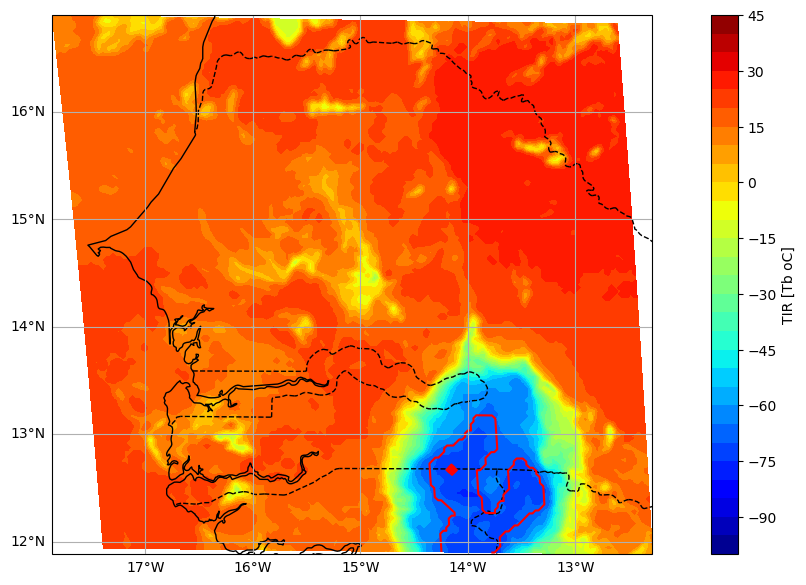

In [9]:
day = 24*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [10]:
# read in input data- TIR and historical core data at t<to
# read in historical cores

list_of_file_names = []

for i in range(0,len(time_core),1):
    current_file = str(time_core[i])    #+'.nc'
    #print(current_file)
    SY= current_file[0:4]
    MM= current_file[4:6]
    DD= current_file[6:8]
    all_file_names = '/prj/Africa_cloud/hist_nflics_nowcasts/'+SY+'/'+MM+'/'+DD+'/Hist_nowcast_v1_wa_'+current_file[0:-2]+'_flt_ALL.nc' 
    #print(all_file_names)
    if os.path.isfile(all_file_names):      
        list_of_file_names.append(all_file_names) # all days in month
    else:
        list_of_file_names.append('file_not_available') # all days in month
            
                     

In [11]:
dumy_temp = np.zeros((len(lat[:,1]),len(lon[1,:])))
hist_cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) 
# hist_cores_temp= np.zeros((len(reg_lat),len(reg_lon)))*np.nan
num_of_missing_hist_core_files = 0

for l in range(0,len(list_of_file_names),1):   #2, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_file_names[l]   #'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    if os.path.isfile(core_filename):      
        ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
        print(l)
        hist_cores_temp = ds['freq'][1,0,:,:].values
        hist_cores[l,:,:] = hist_cores_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
        #hist_cores[l,:,:] = ds['freq'][1,:,:].values
        #time_core[l] = str(core_filename[-15:-3])
        
    else:
        num_of_missing_hist_core_files = num_of_missing_hist_core_files +1
        cores[l,:,:] = dumy_temp
        #tir[l,:,:] = hist_cores_temp 
        #time_core[l] = np.nan#str(core_filename[-15:-3])
        
        

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010000_flt_ALL.nc
0
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010100_flt_ALL.nc
1
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010200_flt_ALL.nc
2
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010300_flt_ALL.nc
3
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010400_flt_ALL.nc
4
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010500_flt_ALL.nc
5
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010600_flt_ALL.nc
6
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010700_flt_ALL.nc
7
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010800_flt_ALL.nc
8
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010900_flt_ALL.nc
9
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/

85
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041400_flt_ALL.nc
86
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041500_flt_ALL.nc
87
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041600_flt_ALL.nc
88
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041700_flt_ALL.nc
89
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041800_flt_ALL.nc
90
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041900_flt_ALL.nc
91
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042000_flt_ALL.nc
92
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042100_flt_ALL.nc
93
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042200_flt_ALL.nc
94
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042300_flt_ALL.nc
95
/prj/Africa_cloud/hist_nflics_nowcast

170
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080300_flt_ALL.nc
171
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080400_flt_ALL.nc
172
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080500_flt_ALL.nc
173
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080600_flt_ALL.nc
174
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080700_flt_ALL.nc
175
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080800_flt_ALL.nc
176
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080900_flt_ALL.nc
177
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081000_flt_ALL.nc
178
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081100_flt_ALL.nc
179
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081200_flt_ALL.nc
180
/prj/Africa_cloud/hist_nfl

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111700_flt_ALL.nc
257
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111800_flt_ALL.nc
258
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111900_flt_ALL.nc
259
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112000_flt_ALL.nc
260
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112100_flt_ALL.nc
261
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112200_flt_ALL.nc
262
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112300_flt_ALL.nc
263
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120000_flt_ALL.nc
264
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120100_flt_ALL.nc
265
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120200_flt_ALL.nc
266
/prj/Africa_cloud/hist_nflics_

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151000_flt_ALL.nc
346
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151100_flt_ALL.nc
347
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151200_flt_ALL.nc
348
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151300_flt_ALL.nc
349
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151400_flt_ALL.nc
350
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151500_flt_ALL.nc
351
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151600_flt_ALL.nc
352
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151700_flt_ALL.nc
353
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151800_flt_ALL.nc
354
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151900_flt_ALL.nc
355
/prj/Africa_cloud/hist_nflics_

430
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006182300_flt_ALL.nc
431
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190000_flt_ALL.nc
432
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190100_flt_ALL.nc
433
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190200_flt_ALL.nc
434
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190300_flt_ALL.nc
435
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190500_flt_ALL.nc
437
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190600_flt_ALL.nc
438
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190700_flt_ALL.nc
439
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190800_flt_ALL.nc
440
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190900_flt_ALL.nc
441
/prj/Af

517
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221400_flt_ALL.nc
518
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221500_flt_ALL.nc
519
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221600_flt_ALL.nc
520
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221700_flt_ALL.nc
521
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221800_flt_ALL.nc
522
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221900_flt_ALL.nc
523
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222000_flt_ALL.nc
524
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222100_flt_ALL.nc
525
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222200_flt_ALL.nc
526
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222300_flt_ALL.nc
527
/prj/Africa_cloud/hist_nfl

602
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260300_flt_ALL.nc
603
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260400_flt_ALL.nc
604
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260500_flt_ALL.nc
605
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260600_flt_ALL.nc
606
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260700_flt_ALL.nc
607
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260800_flt_ALL.nc
608
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260900_flt_ALL.nc
609
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261000_flt_ALL.nc
610
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261100_flt_ALL.nc
611
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261200_flt_ALL.nc
612
/prj/Africa_cloud/hist_nfl

687
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291600_flt_ALL.nc
688
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291700_flt_ALL.nc
689
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291800_flt_ALL.nc
690
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291900_flt_ALL.nc
691
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292000_flt_ALL.nc
692
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292100_flt_ALL.nc
693
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292200_flt_ALL.nc
694
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292300_flt_ALL.nc
695
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300000_flt_ALL.nc
696
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300100_flt_ALL.nc
697
/prj/Africa_cloud/hist_nfl

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030500_flt_ALL.nc
773
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030600_flt_ALL.nc
774
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030700_flt_ALL.nc
775
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030800_flt_ALL.nc
776
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030900_flt_ALL.nc
777
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031000_flt_ALL.nc
778
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031100_flt_ALL.nc
779
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031200_flt_ALL.nc
780
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031300_flt_ALL.nc
781
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031400_flt_ALL.nc
782
/prj/Africa_cloud/hist_nflics_

857
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007061800_flt_ALL.nc
858
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007061900_flt_ALL.nc
859
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062000_flt_ALL.nc
860
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062100_flt_ALL.nc
861
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062200_flt_ALL.nc
862
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062300_flt_ALL.nc
863
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070000_flt_ALL.nc
864
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070100_flt_ALL.nc
865
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070200_flt_ALL.nc
866
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070300_flt_ALL.nc
867
/prj/Africa_cloud/hist_nfl

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007100700_flt_ALL.nc
943
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007100800_flt_ALL.nc
944
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007100900_flt_ALL.nc
945
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101000_flt_ALL.nc
946
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101100_flt_ALL.nc
947
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101200_flt_ALL.nc
948
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101300_flt_ALL.nc
949
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101400_flt_ALL.nc
950
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101500_flt_ALL.nc
951
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101600_flt_ALL.nc
952
/prj/Africa_cloud/hist_nflics_

1027
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007132000_flt_ALL.nc
1028
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007132100_flt_ALL.nc
1029
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007132200_flt_ALL.nc
1030
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007132300_flt_ALL.nc
1031
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140000_flt_ALL.nc
1032
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140100_flt_ALL.nc
1033
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140200_flt_ALL.nc
1034
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140300_flt_ALL.nc
1035
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140400_flt_ALL.nc
1036
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140500_flt_ALL.nc
1037
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007170800_flt_ALL.nc
1112
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007170900_flt_ALL.nc
1113
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171000_flt_ALL.nc
1114
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171100_flt_ALL.nc
1115
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171200_flt_ALL.nc
1116
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171300_flt_ALL.nc
1117
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171400_flt_ALL.nc
1118
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171500_flt_ALL.nc
1119
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171600_flt_ALL.nc
1120
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171700_flt_ALL.nc
1121
/prj/Africa_cloud/hi

1195
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007202000_flt_ALL.nc
1196
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007202100_flt_ALL.nc
1197
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007202200_flt_ALL.nc
1198
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007202300_flt_ALL.nc
1199
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210000_flt_ALL.nc
1200
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210100_flt_ALL.nc
1201
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210200_flt_ALL.nc
1202
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210300_flt_ALL.nc
1203
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210400_flt_ALL.nc
1204
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210500_flt_ALL.nc
1205
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007240800_flt_ALL.nc
1280
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007240900_flt_ALL.nc
1281
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241000_flt_ALL.nc
1282
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241100_flt_ALL.nc
1283
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241200_flt_ALL.nc
1284
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241300_flt_ALL.nc
1285
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241400_flt_ALL.nc
1286
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241500_flt_ALL.nc
1287
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241600_flt_ALL.nc
1288
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241700_flt_ALL.nc
1289
/prj/Africa_cloud/hi

1370
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280300_flt_ALL.nc
1371
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280400_flt_ALL.nc
1372
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280500_flt_ALL.nc
1373
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280600_flt_ALL.nc
1374
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280700_flt_ALL.nc
1375
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280800_flt_ALL.nc
1376
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280900_flt_ALL.nc
1377
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281000_flt_ALL.nc
1378
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281100_flt_ALL.nc
1379
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281200_flt_ALL.nc
1380
/prj/Africa_clo

1454
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311500_flt_ALL.nc
1455
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311600_flt_ALL.nc
1456
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311700_flt_ALL.nc
1457
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311800_flt_ALL.nc
1458
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311900_flt_ALL.nc
1459
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312000_flt_ALL.nc
1460
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312100_flt_ALL.nc
1461
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312200_flt_ALL.nc
1462
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312300_flt_ALL.nc
1463
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010000_flt_ALL.nc
1464
/prj/Africa_clo

1538
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040300_flt_ALL.nc
1539
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040400_flt_ALL.nc
1540
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040500_flt_ALL.nc
1541
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040600_flt_ALL.nc
1542
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040700_flt_ALL.nc
1543
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040800_flt_ALL.nc
1544
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040900_flt_ALL.nc
1545
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041000_flt_ALL.nc
1546
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041100_flt_ALL.nc
1547
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041200_flt_ALL.nc
1548
/prj/Africa_clo

1622
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071500_flt_ALL.nc
1623
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071600_flt_ALL.nc
1624
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071700_flt_ALL.nc
1625
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071800_flt_ALL.nc
1626
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071900_flt_ALL.nc
1627
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072000_flt_ALL.nc
1628
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072100_flt_ALL.nc
1629
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072200_flt_ALL.nc
1630
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072300_flt_ALL.nc
1631
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080000_flt_ALL.nc
1632
/prj/Africa_clo

1706
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110300_flt_ALL.nc
1707
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110400_flt_ALL.nc
1708
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110500_flt_ALL.nc
1709
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110600_flt_ALL.nc
1710
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110700_flt_ALL.nc
1711
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110800_flt_ALL.nc
1712
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110900_flt_ALL.nc
1713
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111000_flt_ALL.nc
1714
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111100_flt_ALL.nc
1715
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111200_flt_ALL.nc
1716
/prj/Africa_clo

1790
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008141500_flt_ALL.nc
1791
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008141600_flt_ALL.nc
1792
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008141700_flt_ALL.nc
1793
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008141800_flt_ALL.nc
1794
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008141900_flt_ALL.nc
1795
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142000_flt_ALL.nc
1796
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142100_flt_ALL.nc
1797
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142200_flt_ALL.nc
1798
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142300_flt_ALL.nc
1799
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150000_flt_ALL.nc
1800
/prj/Africa_clo

1874
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180300_flt_ALL.nc
1875
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180400_flt_ALL.nc
1876
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180500_flt_ALL.nc
1877
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180600_flt_ALL.nc
1878
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180700_flt_ALL.nc
1879
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180800_flt_ALL.nc
1880
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180900_flt_ALL.nc
1881
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181000_flt_ALL.nc
1882
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181100_flt_ALL.nc
1883
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181200_flt_ALL.nc
1884
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211500_flt_ALL.nc
1959
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211600_flt_ALL.nc
1960
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211700_flt_ALL.nc
1961
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211800_flt_ALL.nc
1962
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211900_flt_ALL.nc
1963
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212000_flt_ALL.nc
1964
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212100_flt_ALL.nc
1965
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212200_flt_ALL.nc
1966
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212300_flt_ALL.nc
1967
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220000_flt_ALL.nc
1968
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250300_flt_ALL.nc
2043
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250400_flt_ALL.nc
2044
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250500_flt_ALL.nc
2045
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250600_flt_ALL.nc
2046
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250700_flt_ALL.nc
2047
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250800_flt_ALL.nc
2048
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250900_flt_ALL.nc
2049
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251000_flt_ALL.nc
2050
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251100_flt_ALL.nc
2051
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251200_flt_ALL.nc
2052
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281500_flt_ALL.nc
2127
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281600_flt_ALL.nc
2128
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281700_flt_ALL.nc
2129
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281800_flt_ALL.nc
2130
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281900_flt_ALL.nc
2131
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282000_flt_ALL.nc
2132
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282100_flt_ALL.nc
2133
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282200_flt_ALL.nc
2134
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282300_flt_ALL.nc
2135
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290000_flt_ALL.nc
2136
/prj/Africa_cloud/hi

2210
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010300_flt_ALL.nc
2211
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010400_flt_ALL.nc
2212
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010500_flt_ALL.nc
2213
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010600_flt_ALL.nc
2214
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010700_flt_ALL.nc
2215
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010800_flt_ALL.nc
2216
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010900_flt_ALL.nc
2217
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011000_flt_ALL.nc
2218
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011100_flt_ALL.nc
2219
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011200_flt_ALL.nc
2220
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041500_flt_ALL.nc
2295
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041600_flt_ALL.nc
2296
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041700_flt_ALL.nc
2297
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041800_flt_ALL.nc
2298
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041900_flt_ALL.nc
2299
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042000_flt_ALL.nc
2300
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042100_flt_ALL.nc
2301
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042200_flt_ALL.nc
2302
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042300_flt_ALL.nc
2303
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050000_flt_ALL.nc
2304
/prj/Africa_cloud/hi

2378
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080300_flt_ALL.nc
2379
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080400_flt_ALL.nc
2380
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080500_flt_ALL.nc
2381
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080600_flt_ALL.nc
2382
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080700_flt_ALL.nc
2383
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080800_flt_ALL.nc
2384
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080900_flt_ALL.nc
2385
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081000_flt_ALL.nc
2386
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081100_flt_ALL.nc
2387
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081200_flt_ALL.nc
2388
/prj/Africa_clo

2462
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111500_flt_ALL.nc
2463
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111600_flt_ALL.nc
2464
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111700_flt_ALL.nc
2465
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111800_flt_ALL.nc
2466
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111900_flt_ALL.nc
2467
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112000_flt_ALL.nc
2468
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112100_flt_ALL.nc
2469
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112200_flt_ALL.nc
2470
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112300_flt_ALL.nc
2471
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120000_flt_ALL.nc
2472
/prj/Africa_clo

2546
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150300_flt_ALL.nc
2547
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150400_flt_ALL.nc
2548
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150500_flt_ALL.nc
2549
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150600_flt_ALL.nc
2550
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150700_flt_ALL.nc
2551
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150800_flt_ALL.nc
2552
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150900_flt_ALL.nc
2553
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151000_flt_ALL.nc
2554
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151100_flt_ALL.nc
2555
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151200_flt_ALL.nc
2556
/prj/Africa_clo

2630
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181500_flt_ALL.nc
2631
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181600_flt_ALL.nc
2632
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181700_flt_ALL.nc
2633
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181800_flt_ALL.nc
2634
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181900_flt_ALL.nc
2635
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009182000_flt_ALL.nc
2636
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009182100_flt_ALL.nc
2637
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009182200_flt_ALL.nc
2638
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009182300_flt_ALL.nc
2639
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190000_flt_ALL.nc
2640
/prj/Africa_clo

2714
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220300_flt_ALL.nc
2715
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220400_flt_ALL.nc
2716
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220500_flt_ALL.nc
2717
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220600_flt_ALL.nc
2718
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220700_flt_ALL.nc
2719
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220800_flt_ALL.nc
2720
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220900_flt_ALL.nc
2721
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221000_flt_ALL.nc
2722
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221100_flt_ALL.nc
2723
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221200_flt_ALL.nc
2724
/prj/Africa_clo

2798
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251500_flt_ALL.nc
2799
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251600_flt_ALL.nc
2800
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251700_flt_ALL.nc
2801
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251800_flt_ALL.nc
2802
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251900_flt_ALL.nc
2803
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009252000_flt_ALL.nc
2804
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009252100_flt_ALL.nc
2805
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009252200_flt_ALL.nc
2806
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009252300_flt_ALL.nc
2807
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260000_flt_ALL.nc
2808
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290300_flt_ALL.nc
2883
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290400_flt_ALL.nc
2884
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290500_flt_ALL.nc
2885
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290600_flt_ALL.nc
2886
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290700_flt_ALL.nc
2887
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290900_flt_ALL.nc
2889
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291000_flt_ALL.nc
2890
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291100_flt_ALL.nc
2891
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291200_flt_ALL.nc
2892
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291300_flt_ALL.nc
2893
/

2967
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106021600_flt_ALL.nc
2968
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106021700_flt_ALL.nc
2969
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106021800_flt_ALL.nc
2970
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106021900_flt_ALL.nc
2971
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106022000_flt_ALL.nc
2972
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106022100_flt_ALL.nc
2973
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106022200_flt_ALL.nc
2974
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106022300_flt_ALL.nc
2975
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030000_flt_ALL.nc
2976
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030100_flt_ALL.nc
2977
/prj/Africa_clo

3051
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106060400_flt_ALL.nc
3052
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106060500_flt_ALL.nc
3053
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106060600_flt_ALL.nc
3054
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106060700_flt_ALL.nc
3055
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106060900_flt_ALL.nc
3057
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061000_flt_ALL.nc
3058
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061100_flt_ALL.nc
3059
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061200_flt_ALL.nc
3060
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061300_flt_ALL.nc
3061
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061400_flt_ALL.nc
3

3136
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/09/Hist_nowcast_v1_wa_201106091700_flt_ALL.nc
3137
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/09/Hist_nowcast_v1_wa_201106091800_flt_ALL.nc
3138
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/09/Hist_nowcast_v1_wa_201106091900_flt_ALL.nc
3139
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/09/Hist_nowcast_v1_wa_201106092000_flt_ALL.nc
3140
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/09/Hist_nowcast_v1_wa_201106092100_flt_ALL.nc
3141
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/09/Hist_nowcast_v1_wa_201106092200_flt_ALL.nc
3142
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/09/Hist_nowcast_v1_wa_201106092300_flt_ALL.nc
3143
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100000_flt_ALL.nc
3144
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100100_flt_ALL.nc
3145
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100200_flt_ALL.nc
3146
/prj/Africa_clo

3221
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106130600_flt_ALL.nc
3222
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106130700_flt_ALL.nc
3223
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106130800_flt_ALL.nc
3224
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106130900_flt_ALL.nc
3225
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131000_flt_ALL.nc
3226
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131100_flt_ALL.nc
3227
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131200_flt_ALL.nc
3228
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131300_flt_ALL.nc
3229
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131400_flt_ALL.nc
3230
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131500_flt_ALL.nc
3231
/prj/Africa_clo

3305
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/16/Hist_nowcast_v1_wa_201106161800_flt_ALL.nc
3306
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/16/Hist_nowcast_v1_wa_201106161900_flt_ALL.nc
3307
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/16/Hist_nowcast_v1_wa_201106162000_flt_ALL.nc
3308
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/16/Hist_nowcast_v1_wa_201106162100_flt_ALL.nc
3309
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/16/Hist_nowcast_v1_wa_201106162200_flt_ALL.nc
3310
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/16/Hist_nowcast_v1_wa_201106162300_flt_ALL.nc
3311
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170000_flt_ALL.nc
3312
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170100_flt_ALL.nc
3313
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170200_flt_ALL.nc
3314
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170300_flt_ALL.nc
3315
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106200600_flt_ALL.nc
3390
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106200700_flt_ALL.nc
3391
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106200800_flt_ALL.nc
3392
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106200900_flt_ALL.nc
3393
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201000_flt_ALL.nc
3394
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201100_flt_ALL.nc
3395
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201200_flt_ALL.nc
3396
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201300_flt_ALL.nc
3397
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201400_flt_ALL.nc
3398
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201500_flt_ALL.nc
3399
/prj/Africa_cloud/hi

3473
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/23/Hist_nowcast_v1_wa_201106231800_flt_ALL.nc
3474
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/23/Hist_nowcast_v1_wa_201106231900_flt_ALL.nc
3475
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/23/Hist_nowcast_v1_wa_201106232000_flt_ALL.nc
3476
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/23/Hist_nowcast_v1_wa_201106232100_flt_ALL.nc
3477
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/23/Hist_nowcast_v1_wa_201106232200_flt_ALL.nc
3478
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/23/Hist_nowcast_v1_wa_201106232300_flt_ALL.nc
3479
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240000_flt_ALL.nc
3480
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240100_flt_ALL.nc
3481
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240200_flt_ALL.nc
3482
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240300_flt_ALL.nc
3483
/prj/Africa_clo

3557
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106270600_flt_ALL.nc
3558
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106270700_flt_ALL.nc
3559
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106270800_flt_ALL.nc
3560
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106270900_flt_ALL.nc
3561
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271000_flt_ALL.nc
3562
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271100_flt_ALL.nc
3563
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271200_flt_ALL.nc
3564
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271300_flt_ALL.nc
3565
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271400_flt_ALL.nc
3566
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271500_flt_ALL.nc
3567
/prj/Africa_clo

3641
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/30/Hist_nowcast_v1_wa_201106301800_flt_ALL.nc
3642
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/30/Hist_nowcast_v1_wa_201106301900_flt_ALL.nc
3643
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/30/Hist_nowcast_v1_wa_201106302000_flt_ALL.nc
3644
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/30/Hist_nowcast_v1_wa_201106302100_flt_ALL.nc
3645
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/30/Hist_nowcast_v1_wa_201106302200_flt_ALL.nc
3646
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/30/Hist_nowcast_v1_wa_201106302300_flt_ALL.nc
3647
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010000_flt_ALL.nc
3648
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010100_flt_ALL.nc
3649
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010200_flt_ALL.nc
3650
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010300_flt_ALL.nc
3651
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107040600_flt_ALL.nc
3726
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107040700_flt_ALL.nc
3727
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107040800_flt_ALL.nc
3728
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107040900_flt_ALL.nc
3729
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041000_flt_ALL.nc
3730
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041100_flt_ALL.nc
3731
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041200_flt_ALL.nc
3732
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041300_flt_ALL.nc
3733
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041400_flt_ALL.nc
3734
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041500_flt_ALL.nc
3735
/prj/Africa_cloud/hi

3809
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/07/Hist_nowcast_v1_wa_201107071800_flt_ALL.nc
3810
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/07/Hist_nowcast_v1_wa_201107071900_flt_ALL.nc
3811
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/07/Hist_nowcast_v1_wa_201107072000_flt_ALL.nc
3812
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/07/Hist_nowcast_v1_wa_201107072100_flt_ALL.nc
3813
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/07/Hist_nowcast_v1_wa_201107072200_flt_ALL.nc
3814
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/07/Hist_nowcast_v1_wa_201107072300_flt_ALL.nc
3815
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080000_flt_ALL.nc
3816
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080100_flt_ALL.nc
3817
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080200_flt_ALL.nc
3818
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080300_flt_ALL.nc
3819
/prj/Africa_clo

3893
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107110600_flt_ALL.nc
3894
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107110700_flt_ALL.nc
3895
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107110800_flt_ALL.nc
3896
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107110900_flt_ALL.nc
3897
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111000_flt_ALL.nc
3898
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111100_flt_ALL.nc
3899
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111200_flt_ALL.nc
3900
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111300_flt_ALL.nc
3901
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111400_flt_ALL.nc
3902
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111500_flt_ALL.nc
3903
/prj/Africa_clo

3984
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150100_flt_ALL.nc
3985
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150200_flt_ALL.nc
3986
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150300_flt_ALL.nc
3987
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150400_flt_ALL.nc
3988
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150500_flt_ALL.nc
3989
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150600_flt_ALL.nc
3990
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150700_flt_ALL.nc
3991
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150800_flt_ALL.nc
3992
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107150900_flt_ALL.nc
3993
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151000_flt_ALL.nc
3994
/prj/Africa_clo

4068
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107181300_flt_ALL.nc
4069
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107181400_flt_ALL.nc
4070
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107181500_flt_ALL.nc
4071
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107181600_flt_ALL.nc
4072
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107181700_flt_ALL.nc
4073
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107181800_flt_ALL.nc
4074
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107181900_flt_ALL.nc
4075
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107182000_flt_ALL.nc
4076
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107182100_flt_ALL.nc
4077
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107182200_flt_ALL.nc
4078
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220100_flt_ALL.nc
4153
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220200_flt_ALL.nc
4154
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220300_flt_ALL.nc
4155
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220400_flt_ALL.nc
4156
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220500_flt_ALL.nc
4157
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220600_flt_ALL.nc
4158
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220700_flt_ALL.nc
4159
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107220900_flt_ALL.nc
4161
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221000_flt_ALL.nc
4162
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221100_flt_ALL.nc
4163
/

/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107251400_flt_ALL.nc
4238
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107251500_flt_ALL.nc
4239
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107251600_flt_ALL.nc
4240
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107251700_flt_ALL.nc
4241
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107251800_flt_ALL.nc
4242
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107251900_flt_ALL.nc
4243
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107252000_flt_ALL.nc
4244
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107252100_flt_ALL.nc
4245
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107252200_flt_ALL.nc
4246
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/25/Hist_nowcast_v1_wa_201107252300_flt_ALL.nc
4247
/prj/Africa_cloud/hi

4321
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290200_flt_ALL.nc
4322
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290300_flt_ALL.nc
4323
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290400_flt_ALL.nc
4324
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290500_flt_ALL.nc
4325
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290600_flt_ALL.nc
4326
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290700_flt_ALL.nc
4327
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290800_flt_ALL.nc
4328
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107290900_flt_ALL.nc
4329
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291000_flt_ALL.nc
4330
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291100_flt_ALL.nc
4331
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108011400_flt_ALL.nc
4406
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108011500_flt_ALL.nc
4407
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108011600_flt_ALL.nc
4408
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108011700_flt_ALL.nc
4409
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108011800_flt_ALL.nc
4410
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108011900_flt_ALL.nc
4411
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108012000_flt_ALL.nc
4412
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108012100_flt_ALL.nc
4413
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108012200_flt_ALL.nc
4414
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/01/Hist_nowcast_v1_wa_201108012300_flt_ALL.nc
4415
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050200_flt_ALL.nc
4490
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050300_flt_ALL.nc
4491
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050400_flt_ALL.nc
4492
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050500_flt_ALL.nc
4493
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050600_flt_ALL.nc
4494
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050700_flt_ALL.nc
4495
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050800_flt_ALL.nc
4496
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108050900_flt_ALL.nc
4497
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051000_flt_ALL.nc
4498
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051100_flt_ALL.nc
4499
/prj/Africa_cloud/hi

4573
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108081400_flt_ALL.nc
4574
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108081500_flt_ALL.nc
4575
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108081600_flt_ALL.nc
4576
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108081700_flt_ALL.nc
4577
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108081800_flt_ALL.nc
4578
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108081900_flt_ALL.nc
4579
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108082000_flt_ALL.nc
4580
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108082100_flt_ALL.nc
4581
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108082200_flt_ALL.nc
4582
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/08/Hist_nowcast_v1_wa_201108082300_flt_ALL.nc
4583
/prj/Africa_clo

4657
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120200_flt_ALL.nc
4658
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120300_flt_ALL.nc
4659
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120400_flt_ALL.nc
4660
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120500_flt_ALL.nc
4661
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120600_flt_ALL.nc
4662
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120700_flt_ALL.nc
4663
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120800_flt_ALL.nc
4664
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108120900_flt_ALL.nc
4665
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121000_flt_ALL.nc
4666
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121100_flt_ALL.nc
4667
/prj/Africa_clo

4741
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108151400_flt_ALL.nc
4742
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108151500_flt_ALL.nc
4743
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108151600_flt_ALL.nc
4744
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108151700_flt_ALL.nc
4745
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108151800_flt_ALL.nc
4746
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108151900_flt_ALL.nc
4747
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108152000_flt_ALL.nc
4748
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108152100_flt_ALL.nc
4749
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108152200_flt_ALL.nc
4750
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/15/Hist_nowcast_v1_wa_201108152300_flt_ALL.nc
4751
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190200_flt_ALL.nc
4826
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190300_flt_ALL.nc
4827
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190400_flt_ALL.nc
4828
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190500_flt_ALL.nc
4829
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190600_flt_ALL.nc
4830
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190700_flt_ALL.nc
4831
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190800_flt_ALL.nc
4832
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108190900_flt_ALL.nc
4833
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191000_flt_ALL.nc
4834
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191100_flt_ALL.nc
4835
/prj/Africa_cloud/hi

4909
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108221400_flt_ALL.nc
4910
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108221500_flt_ALL.nc
4911
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108221600_flt_ALL.nc
4912
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108221700_flt_ALL.nc
4913
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108221800_flt_ALL.nc
4914
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108221900_flt_ALL.nc
4915
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108222000_flt_ALL.nc
4916
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108222100_flt_ALL.nc
4917
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108222200_flt_ALL.nc
4918
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/22/Hist_nowcast_v1_wa_201108222300_flt_ALL.nc
4919
/prj/Africa_clo

4993
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260200_flt_ALL.nc
4994
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260300_flt_ALL.nc
4995
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260400_flt_ALL.nc
4996
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260500_flt_ALL.nc
4997
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260600_flt_ALL.nc
4998
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260700_flt_ALL.nc
4999
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260800_flt_ALL.nc
5000
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108260900_flt_ALL.nc
5001
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261000_flt_ALL.nc
5002
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261100_flt_ALL.nc
5003
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108291400_flt_ALL.nc
5078
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108291500_flt_ALL.nc
5079
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108291600_flt_ALL.nc
5080
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108291700_flt_ALL.nc
5081
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108291800_flt_ALL.nc
5082
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108291900_flt_ALL.nc
5083
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108292000_flt_ALL.nc
5084
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108292100_flt_ALL.nc
5085
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108292200_flt_ALL.nc
5086
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/29/Hist_nowcast_v1_wa_201108292300_flt_ALL.nc
5087
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020200_flt_ALL.nc
5162
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020300_flt_ALL.nc
5163
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020400_flt_ALL.nc
5164
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020500_flt_ALL.nc
5165
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020600_flt_ALL.nc
5166
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020700_flt_ALL.nc
5167
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020800_flt_ALL.nc
5168
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109020900_flt_ALL.nc
5169
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021000_flt_ALL.nc
5170
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021100_flt_ALL.nc
5171
/prj/Africa_cloud/hi

5247
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109051600_flt_ALL.nc
5248
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109051700_flt_ALL.nc
5249
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109051800_flt_ALL.nc
5250
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109051900_flt_ALL.nc
5251
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109052000_flt_ALL.nc
5252
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109052100_flt_ALL.nc
5253
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109052200_flt_ALL.nc
5254
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/05/Hist_nowcast_v1_wa_201109052300_flt_ALL.nc
5255
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060000_flt_ALL.nc
5256
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060100_flt_ALL.nc
5257
/prj/Africa_clo

5331
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109090400_flt_ALL.nc
5332
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109090500_flt_ALL.nc
5333
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109090600_flt_ALL.nc
5334
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109090700_flt_ALL.nc
5335
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109090800_flt_ALL.nc
5336
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109090900_flt_ALL.nc
5337
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091000_flt_ALL.nc
5338
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091100_flt_ALL.nc
5339
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091200_flt_ALL.nc
5340
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091300_flt_ALL.nc
5341
/prj/Africa_clo

5415
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109121600_flt_ALL.nc
5416
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109121700_flt_ALL.nc
5417
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109121800_flt_ALL.nc
5418
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109121900_flt_ALL.nc
5419
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109122000_flt_ALL.nc
5420
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109122100_flt_ALL.nc
5421
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109122200_flt_ALL.nc
5422
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/12/Hist_nowcast_v1_wa_201109122300_flt_ALL.nc
5423
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130000_flt_ALL.nc
5424
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130100_flt_ALL.nc
5425
/prj/Africa_clo

5500
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109160500_flt_ALL.nc
5501
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109160600_flt_ALL.nc
5502
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109160700_flt_ALL.nc
5503
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109160800_flt_ALL.nc
5504
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109160900_flt_ALL.nc
5505
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161000_flt_ALL.nc
5506
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161100_flt_ALL.nc
5507
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161200_flt_ALL.nc
5508
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161300_flt_ALL.nc
5509
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161400_flt_ALL.nc
5510
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/19/Hist_nowcast_v1_wa_201109191700_flt_ALL.nc
5585
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/19/Hist_nowcast_v1_wa_201109191800_flt_ALL.nc
5586
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/19/Hist_nowcast_v1_wa_201109191900_flt_ALL.nc
5587
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/19/Hist_nowcast_v1_wa_201109192000_flt_ALL.nc
5588
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/19/Hist_nowcast_v1_wa_201109192100_flt_ALL.nc
5589
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/19/Hist_nowcast_v1_wa_201109192200_flt_ALL.nc
5590
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/19/Hist_nowcast_v1_wa_201109192300_flt_ALL.nc
5591
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200000_flt_ALL.nc
5592
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200100_flt_ALL.nc
5593
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200200_flt_ALL.nc
5594
/prj/Africa_cloud/hi

5668
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109230500_flt_ALL.nc
5669
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109230600_flt_ALL.nc
5670
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109230700_flt_ALL.nc
5671
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109230800_flt_ALL.nc
5672
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109230900_flt_ALL.nc
5673
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231000_flt_ALL.nc
5674
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231100_flt_ALL.nc
5675
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231200_flt_ALL.nc
5676
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231300_flt_ALL.nc
5677
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231400_flt_ALL.nc
5678
/prj/Africa_clo

5754
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/26/Hist_nowcast_v1_wa_201109261900_flt_ALL.nc
5755
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/26/Hist_nowcast_v1_wa_201109262000_flt_ALL.nc
5756
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/26/Hist_nowcast_v1_wa_201109262100_flt_ALL.nc
5757
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/26/Hist_nowcast_v1_wa_201109262200_flt_ALL.nc
5758
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/26/Hist_nowcast_v1_wa_201109262300_flt_ALL.nc
5759
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270000_flt_ALL.nc
5760
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270100_flt_ALL.nc
5761
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270200_flt_ALL.nc
5762
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270300_flt_ALL.nc
5763
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270400_flt_ALL.nc
5764
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109300700_flt_ALL.nc
5839
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109300800_flt_ALL.nc
5840
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109300900_flt_ALL.nc
5841
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301000_flt_ALL.nc
5842
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301100_flt_ALL.nc
5843
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301200_flt_ALL.nc
5844
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301300_flt_ALL.nc
5845
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301400_flt_ALL.nc
5846
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301500_flt_ALL.nc
5847
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301600_flt_ALL.nc
5848
/prj/Africa_cloud/hi

5922
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/03/Hist_nowcast_v1_wa_201206031900_flt_ALL.nc
5923
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/03/Hist_nowcast_v1_wa_201206032000_flt_ALL.nc
5924
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/03/Hist_nowcast_v1_wa_201206032100_flt_ALL.nc
5925
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/03/Hist_nowcast_v1_wa_201206032200_flt_ALL.nc
5926
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/03/Hist_nowcast_v1_wa_201206032300_flt_ALL.nc
5927
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040000_flt_ALL.nc
5928
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040100_flt_ALL.nc
5929
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040200_flt_ALL.nc
5930
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040300_flt_ALL.nc
5931
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040400_flt_ALL.nc
5932
/prj/Africa_clo

6007
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206070800_flt_ALL.nc
6008
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206070900_flt_ALL.nc
6009
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071000_flt_ALL.nc
6010
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071100_flt_ALL.nc
6011
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071200_flt_ALL.nc
6012
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071300_flt_ALL.nc
6013
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071400_flt_ALL.nc
6014
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071500_flt_ALL.nc
6015
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071600_flt_ALL.nc
6016
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071700_flt_ALL.nc
6017
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/10/Hist_nowcast_v1_wa_201206102300_flt_ALL.nc
6095
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110000_flt_ALL.nc
6096
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110100_flt_ALL.nc
6097
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110200_flt_ALL.nc
6098
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110300_flt_ALL.nc
6099
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110400_flt_ALL.nc
6100
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110500_flt_ALL.nc
6101
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110600_flt_ALL.nc
6102
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110700_flt_ALL.nc
6103
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110800_flt_ALL.nc
6104
/prj/Africa_cloud/hi

6178
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141100_flt_ALL.nc
6179
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141200_flt_ALL.nc
6180
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141300_flt_ALL.nc
6181
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141400_flt_ALL.nc
6182
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141500_flt_ALL.nc
6183
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141600_flt_ALL.nc
6184
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141700_flt_ALL.nc
6185
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141800_flt_ALL.nc
6186
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206141900_flt_ALL.nc
6187
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206142000_flt_ALL.nc
6188
/prj/Africa_clo

6262
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/17/Hist_nowcast_v1_wa_201206172300_flt_ALL.nc
6263
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180000_flt_ALL.nc
6264
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180100_flt_ALL.nc
6265
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180200_flt_ALL.nc
6266
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180300_flt_ALL.nc
6267
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180400_flt_ALL.nc
6268
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180500_flt_ALL.nc
6269
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180600_flt_ALL.nc
6270
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180700_flt_ALL.nc
6271
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180800_flt_ALL.nc
6272
/prj/Africa_clo

6346
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211100_flt_ALL.nc
6347
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211200_flt_ALL.nc
6348
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211300_flt_ALL.nc
6349
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211400_flt_ALL.nc
6350
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211500_flt_ALL.nc
6351
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211600_flt_ALL.nc
6352
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211700_flt_ALL.nc
6353
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211800_flt_ALL.nc
6354
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206211900_flt_ALL.nc
6355
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206212000_flt_ALL.nc
6356
/prj/Africa_clo

6430
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/24/Hist_nowcast_v1_wa_201206242300_flt_ALL.nc
6431
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250000_flt_ALL.nc
6432
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250100_flt_ALL.nc
6433
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250200_flt_ALL.nc
6434
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250300_flt_ALL.nc
6435
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250400_flt_ALL.nc
6436
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250500_flt_ALL.nc
6437
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250600_flt_ALL.nc
6438
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250700_flt_ALL.nc
6439
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250800_flt_ALL.nc
6440
/prj/Africa_clo

6514
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281100_flt_ALL.nc
6515
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281200_flt_ALL.nc
6516
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281300_flt_ALL.nc
6517
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281400_flt_ALL.nc
6518
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281500_flt_ALL.nc
6519
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281600_flt_ALL.nc
6520
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281700_flt_ALL.nc
6521
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281800_flt_ALL.nc
6522
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206281900_flt_ALL.nc
6523
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206282000_flt_ALL.nc
6524
/prj/Africa_clo

6598
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/01/Hist_nowcast_v1_wa_201207012300_flt_ALL.nc
6599
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020000_flt_ALL.nc
6600
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020100_flt_ALL.nc
6601
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020200_flt_ALL.nc
6602
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020300_flt_ALL.nc
6603
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020400_flt_ALL.nc
6604
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020500_flt_ALL.nc
6605
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020600_flt_ALL.nc
6606
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020700_flt_ALL.nc
6607
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020800_flt_ALL.nc
6608
/prj/Africa_clo

6683
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/05/Hist_nowcast_v1_wa_201207051200_flt_ALL.nc
6684
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/05/Hist_nowcast_v1_wa_201207051300_flt_ALL.nc
6685
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/05/Hist_nowcast_v1_wa_201207051400_flt_ALL.nc
6686
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/05/Hist_nowcast_v1_wa_201207051500_flt_ALL.nc
6687
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/05/Hist_nowcast_v1_wa_201207051600_flt_ALL.nc
6688
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/05/Hist_nowcast_v1_wa_201207051700_flt_ALL.nc
6689
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060000_flt_ALL.nc
6690
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060100_flt_ALL.nc
6691
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060200_flt_ALL.nc
6692
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060300_flt_ALL.nc
6693
/prj/Africa_clo

6767
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207090600_flt_ALL.nc
6768
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207090700_flt_ALL.nc
6769
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207090800_flt_ALL.nc
6770
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207090900_flt_ALL.nc
6771
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091000_flt_ALL.nc
6772
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091100_flt_ALL.nc
6773
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091200_flt_ALL.nc
6774
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091300_flt_ALL.nc
6775
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091400_flt_ALL.nc
6776
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091500_flt_ALL.nc
6777
/prj/Africa_clo

6853
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/12/Hist_nowcast_v1_wa_201207122000_flt_ALL.nc
6854
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/12/Hist_nowcast_v1_wa_201207122100_flt_ALL.nc
6855
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/12/Hist_nowcast_v1_wa_201207122200_flt_ALL.nc
6856
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/12/Hist_nowcast_v1_wa_201207122300_flt_ALL.nc
6857
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130000_flt_ALL.nc
6858
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130100_flt_ALL.nc
6859
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130200_flt_ALL.nc
6860
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130300_flt_ALL.nc
6861
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130400_flt_ALL.nc
6862
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130500_flt_ALL.nc
6863
/prj/Africa_clo

6937
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207160800_flt_ALL.nc
6938
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207160900_flt_ALL.nc
6939
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161000_flt_ALL.nc
6940
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161100_flt_ALL.nc
6941
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161200_flt_ALL.nc
6942
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161300_flt_ALL.nc
6943
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161400_flt_ALL.nc
6944
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161500_flt_ALL.nc
6945
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161600_flt_ALL.nc
6946
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161700_flt_ALL.nc
6947
/prj/Africa_clo

7021
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/19/Hist_nowcast_v1_wa_201207192000_flt_ALL.nc
7022
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/19/Hist_nowcast_v1_wa_201207192100_flt_ALL.nc
7023
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/19/Hist_nowcast_v1_wa_201207192200_flt_ALL.nc
7024
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/19/Hist_nowcast_v1_wa_201207192300_flt_ALL.nc
7025
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200000_flt_ALL.nc
7026
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200100_flt_ALL.nc
7027
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200200_flt_ALL.nc
7028
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200300_flt_ALL.nc
7029
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200400_flt_ALL.nc
7030
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200500_flt_ALL.nc
7031
/prj/Africa_clo

7105
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207230800_flt_ALL.nc
7106
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207230900_flt_ALL.nc
7107
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231000_flt_ALL.nc
7108
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231100_flt_ALL.nc
7109
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231200_flt_ALL.nc
7110
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231300_flt_ALL.nc
7111
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231400_flt_ALL.nc
7112
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231500_flt_ALL.nc
7113
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231600_flt_ALL.nc
7114
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231700_flt_ALL.nc
7115
/prj/Africa_clo

7189
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/26/Hist_nowcast_v1_wa_201207262000_flt_ALL.nc
7190
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/26/Hist_nowcast_v1_wa_201207262100_flt_ALL.nc
7191
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/26/Hist_nowcast_v1_wa_201207262200_flt_ALL.nc
7192
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/26/Hist_nowcast_v1_wa_201207262300_flt_ALL.nc
7193
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270000_flt_ALL.nc
7194
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270100_flt_ALL.nc
7195
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270200_flt_ALL.nc
7196
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270300_flt_ALL.nc
7197
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270400_flt_ALL.nc
7198
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270500_flt_ALL.nc
7199
/prj/Africa_clo

7273
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207300800_flt_ALL.nc
7274
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207300900_flt_ALL.nc
7275
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301000_flt_ALL.nc
7276
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301100_flt_ALL.nc
7277
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301200_flt_ALL.nc
7278
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301300_flt_ALL.nc
7279
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301400_flt_ALL.nc
7280
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301500_flt_ALL.nc
7281
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301600_flt_ALL.nc
7282
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301700_flt_ALL.nc
7283
/prj/Africa_clo

7357
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/02/Hist_nowcast_v1_wa_201208022000_flt_ALL.nc
7358
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/02/Hist_nowcast_v1_wa_201208022100_flt_ALL.nc
7359
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/02/Hist_nowcast_v1_wa_201208022200_flt_ALL.nc
7360
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/02/Hist_nowcast_v1_wa_201208022300_flt_ALL.nc
7361
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030000_flt_ALL.nc
7362
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030100_flt_ALL.nc
7363
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030200_flt_ALL.nc
7364
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030300_flt_ALL.nc
7365
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030400_flt_ALL.nc
7366
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030500_flt_ALL.nc
7367
/prj/Africa_clo

7441
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208060800_flt_ALL.nc
7442
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208060900_flt_ALL.nc
7443
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061000_flt_ALL.nc
7444
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061100_flt_ALL.nc
7445
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061200_flt_ALL.nc
7446
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061300_flt_ALL.nc
7447
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061400_flt_ALL.nc
7448
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061500_flt_ALL.nc
7449
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061600_flt_ALL.nc
7450
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208061700_flt_ALL.nc
7451
/prj/Africa_clo

7525
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/09/Hist_nowcast_v1_wa_201208092000_flt_ALL.nc
7526
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/09/Hist_nowcast_v1_wa_201208092100_flt_ALL.nc
7527
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/09/Hist_nowcast_v1_wa_201208092200_flt_ALL.nc
7528
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/09/Hist_nowcast_v1_wa_201208092300_flt_ALL.nc
7529
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100000_flt_ALL.nc
7530
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100100_flt_ALL.nc
7531
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100200_flt_ALL.nc
7532
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100300_flt_ALL.nc
7533
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100400_flt_ALL.nc
7534
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100500_flt_ALL.nc
7535
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208130800_flt_ALL.nc
7610
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208130900_flt_ALL.nc
7611
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131000_flt_ALL.nc
7612
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131100_flt_ALL.nc
7613
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131200_flt_ALL.nc
7614
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131300_flt_ALL.nc
7615
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131400_flt_ALL.nc
7616
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131500_flt_ALL.nc
7617
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131600_flt_ALL.nc
7618
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208131700_flt_ALL.nc
7619
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/16/Hist_nowcast_v1_wa_201208162000_flt_ALL.nc
7694
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/16/Hist_nowcast_v1_wa_201208162100_flt_ALL.nc
7695
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/16/Hist_nowcast_v1_wa_201208162200_flt_ALL.nc
7696
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/16/Hist_nowcast_v1_wa_201208162300_flt_ALL.nc
7697
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170000_flt_ALL.nc
7698
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170100_flt_ALL.nc
7699
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170200_flt_ALL.nc
7700
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170300_flt_ALL.nc
7701
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170400_flt_ALL.nc
7702
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170500_flt_ALL.nc
7703
/prj/Africa_cloud/hi

7777
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208200800_flt_ALL.nc
7778
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208200900_flt_ALL.nc
7779
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201000_flt_ALL.nc
7780
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201100_flt_ALL.nc
7781
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201200_flt_ALL.nc
7782
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201300_flt_ALL.nc
7783
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201400_flt_ALL.nc
7784
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201500_flt_ALL.nc
7785
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201600_flt_ALL.nc
7786
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208201700_flt_ALL.nc
7787
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/23/Hist_nowcast_v1_wa_201208232000_flt_ALL.nc
7862
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/23/Hist_nowcast_v1_wa_201208232100_flt_ALL.nc
7863
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/23/Hist_nowcast_v1_wa_201208232200_flt_ALL.nc
7864
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/23/Hist_nowcast_v1_wa_201208232300_flt_ALL.nc
7865
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240000_flt_ALL.nc
7866
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240100_flt_ALL.nc
7867
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240200_flt_ALL.nc
7868
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240300_flt_ALL.nc
7869
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240400_flt_ALL.nc
7870
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240500_flt_ALL.nc
7871
/prj/Africa_cloud/hi

7945
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208270800_flt_ALL.nc
7946
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208270900_flt_ALL.nc
7947
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271000_flt_ALL.nc
7948
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271100_flt_ALL.nc
7949
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271200_flt_ALL.nc
7950
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271300_flt_ALL.nc
7951
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271400_flt_ALL.nc
7952
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271500_flt_ALL.nc
7953
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271600_flt_ALL.nc
7954
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208271700_flt_ALL.nc
7955
/prj/Africa_clo

8029
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/30/Hist_nowcast_v1_wa_201208302000_flt_ALL.nc
8030
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/30/Hist_nowcast_v1_wa_201208302100_flt_ALL.nc
8031
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/30/Hist_nowcast_v1_wa_201208302200_flt_ALL.nc
8032
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/30/Hist_nowcast_v1_wa_201208302300_flt_ALL.nc
8033
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208310000_flt_ALL.nc
8034
file_not_available
file_not_available
file_not_available
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208310500_flt_ALL.nc
8039
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208310600_flt_ALL.nc
8040
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208310700_flt_ALL.nc
8041
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208310800_flt_ALL.nc
8042
/prj/Africa_cloud/hist_nflics_nowcast

8116
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031100_flt_ALL.nc
8117
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031200_flt_ALL.nc
8118
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031300_flt_ALL.nc
8119
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031400_flt_ALL.nc
8120
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031500_flt_ALL.nc
8121
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031600_flt_ALL.nc
8122
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031700_flt_ALL.nc
8123
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031800_flt_ALL.nc
8124
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209031900_flt_ALL.nc
8125
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209032000_flt_ALL.nc
8126
/prj/Africa_clo

8200
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/06/Hist_nowcast_v1_wa_201209062300_flt_ALL.nc
8201
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070000_flt_ALL.nc
8202
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070100_flt_ALL.nc
8203
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070200_flt_ALL.nc
8204
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070300_flt_ALL.nc
8205
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070400_flt_ALL.nc
8206
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070500_flt_ALL.nc
8207
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070600_flt_ALL.nc
8208
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070700_flt_ALL.nc
8209
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209070800_flt_ALL.nc
8210
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101100_flt_ALL.nc
8285
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101200_flt_ALL.nc
8286
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101300_flt_ALL.nc
8287
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101400_flt_ALL.nc
8288
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101500_flt_ALL.nc
8289
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101600_flt_ALL.nc
8290
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101700_flt_ALL.nc
8291
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101800_flt_ALL.nc
8292
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209101900_flt_ALL.nc
8293
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/10/Hist_nowcast_v1_wa_201209102000_flt_ALL.nc
8294
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/13/Hist_nowcast_v1_wa_201209132300_flt_ALL.nc
8369
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140000_flt_ALL.nc
8370
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140100_flt_ALL.nc
8371
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140200_flt_ALL.nc
8372
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140300_flt_ALL.nc
8373
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140400_flt_ALL.nc
8374
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140500_flt_ALL.nc
8375
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140600_flt_ALL.nc
8376
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140800_flt_ALL.nc
8378
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209140900_flt_ALL.nc
8379
f

8455
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209171400_flt_ALL.nc
8456
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209171500_flt_ALL.nc
8457
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209171600_flt_ALL.nc
8458
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209171700_flt_ALL.nc
8459
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209171800_flt_ALL.nc
8460
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209171900_flt_ALL.nc
8461
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209172000_flt_ALL.nc
8462
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209172100_flt_ALL.nc
8463
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209172200_flt_ALL.nc
8464
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/17/Hist_nowcast_v1_wa_201209172300_flt_ALL.nc
8465
/prj/Africa_clo

8539
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210200_flt_ALL.nc
8540
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210300_flt_ALL.nc
8541
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210400_flt_ALL.nc
8542
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210500_flt_ALL.nc
8543
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210600_flt_ALL.nc
8544
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210700_flt_ALL.nc
8545
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210800_flt_ALL.nc
8546
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209210900_flt_ALL.nc
8547
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209211000_flt_ALL.nc
8548
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209211100_flt_ALL.nc
8549
/prj/Africa_clo

8625
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209241600_flt_ALL.nc
8626
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209241700_flt_ALL.nc
8627
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209241800_flt_ALL.nc
8628
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209241900_flt_ALL.nc
8629
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209242000_flt_ALL.nc
8630
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209242100_flt_ALL.nc
8631
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209242200_flt_ALL.nc
8632
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/24/Hist_nowcast_v1_wa_201209242300_flt_ALL.nc
8633
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209250000_flt_ALL.nc
8634
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209250100_flt_ALL.nc
8635
/prj/Africa_clo

8711
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209280600_flt_ALL.nc
8712
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209280700_flt_ALL.nc
8713
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209280800_flt_ALL.nc
8714
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209280900_flt_ALL.nc
8715
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209281000_flt_ALL.nc
8716
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209281100_flt_ALL.nc
8717
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209281200_flt_ALL.nc
8718
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209281300_flt_ALL.nc
8719
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209281400_flt_ALL.nc
8720
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209281500_flt_ALL.nc
8721
/prj/Africa_clo

In [12]:
num_of_missing_hist_core_files

57

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


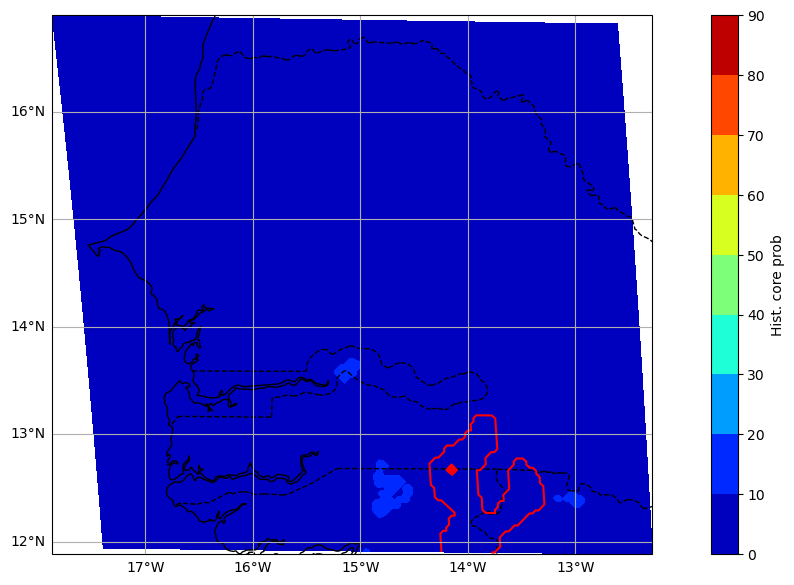

In [13]:
day = 24*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, hist_cores[day,:,:], lon, lat, levels=np.arange(0,100,10), cbar_label='Hist. core prob', cmap='jet')
# ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [14]:
# input data- cores_t_0: 
# starting at 
num_frames= 1  #8  # previous 2 hours of images to predict 1 hr later
t0= 0  #1   #*4 # # 15 min  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]
hist_cores_t_0 = hist_cores[0:-num_frames-t0, :-a,b:]

# normalize training data 
#cores_t_0 = cores_t_0/np.max(cores_t_0)
ind = np.where(cores_t_0>0)
cores_t_0[ind] = 1
#hist_cores_t_0 = hist_cores_t_0/np.max(hist_cores_t_0)


#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
#print(np.unique(cores_t_plus_xhr))
#print(np.unique(cores_t_0))
#print(np.unique(hist_cores_t_0))


In [15]:
# open a file, where you stored the pickled data
#file = open('pkl_files/WA_subdomain_cores_2hr_back_multichannel.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#hist_cores_t_0= data[2]
#cores_t_plus_xhr= data[3]


In [16]:
ind_tir = np.where(tir_t_0>-30)
tir_t_0[ind_tir] = 0
tir_t_0[np.isnan(tir_t_0)] = 0
tir_t_0 = tir_t_0/np.min(tir_t_0)

In [17]:
print(np.unique(cores_t_plus_xhr))
print(np.unique(cores_t_0))
print(np.unique(tir_t_0))
print(np.unique(hist_cores_t_0))


[0. 1.]
[0. 1.]
[-0.          0.1734104   0.17919075  0.1849711   0.19075145  0.19653179
  0.20231214  0.20809249  0.21387283  0.21965318  0.22543353  0.23121387
  0.23699422  0.24277457  0.24855491  0.25433526  0.26011561  0.26589595
  0.2716763   0.27745665  0.28323699  0.28901734  0.29479769  0.30057803
  0.30635838  0.31213873  0.31791908  0.32369942  0.32947977  0.33526012
  0.34104046  0.34682081  0.35260116  0.3583815   0.36416185  0.3699422
  0.37572254  0.38150289  0.38728324  0.39306358  0.39884393  0.40462428
  0.41040462  0.41618497  0.42196532  0.42774566  0.43352601  0.43930636
  0.44508671  0.45086705  0.4566474   0.46242775  0.46820809  0.47398844
  0.47976879  0.48554913  0.49132948  0.49710983  0.50289017  0.50867052
  0.51445087  0.52023121  0.52601156  0.53179191  0.53757225  0.5433526
  0.54913295  0.55491329  0.56069364  0.56647399  0.57803468  0.58381503
  0.58959538  0.59537572  0.60115607  0.61271676  0.61849711  0.62427746
  0.6416185   0.65317919  0.66473988 

In [18]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(cores_t_0.shape)
print(hist_cores_t_0.shape)
print(tir_t_0.shape)
print(cores_t_plus_xhr.shape)
a= 45
b= 48
num_frames= 1  #8  # previous 2 hours of images to predict 1 hr later
t0= 0

(8783, 128, 128)
(8783, 128, 128)
(8783, 128, 128)
(8783, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


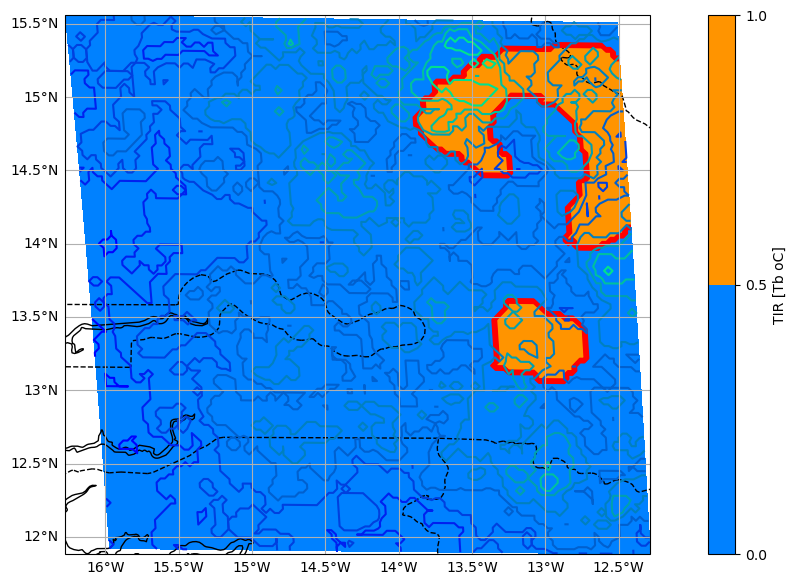

In [19]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores_t_0[day,:,:], colors='r')
ax.contour(lon[:-a,b:], lat[:-a,b:], hist_cores_t_0[day,:,:], cmap='winter')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [44]:
# save variables 
#with open('pkl_files/WA_subdomain_cores_4hr_back_multichannel.pkl', 'wb') as file: 
 #         pickle.dump([cores_t_0,tir_t_0,hist_cores_t_0,cores_t_plus_xhr], file) 
        

In [37]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 3 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [38]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=2, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)
x = layers.Dense(1, activation="sigmoid")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [39]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 128, 128,   0         
                             3)]                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 128, 128, 8  8832      
                             )                                   
                                                                 
 batch_normalization_2 (Batc  (None, None, 128, 128, 8  32       
 hNormalization)             )                                   
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 128, 128, 8  4640      
                             )                                   
                                                                 
 batch_normalization_3 (Batc  (None, None, 128, 128, 8  32 

In [40]:
num_frames= 8   # 4  hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 100
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, 1))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, 1))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    x_train[i,:,:,:,1]= tir_t_0[i*num_frames:(i+1)*num_frames,:,:]
    x_train[i,:,:,:,2]= hist_cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    x_val[i,:,:,:,1]= tir_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    x_val[i,:,:,:,2]= hist_cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]


In [41]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
#batch_size-val_samples
#batch_size

(997, 8, 128, 128, 3)
(997, 8, 128, 128, 1)
(100, 8, 128, 128, 3)
(100, 8, 128, 128, 1)


In [42]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20 # 20
batch_size = 4 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

2024-01-04 11:35:27.504317: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1568145408 exceeds 10% of free system memory.
2024-01-04 11:35:29.208251: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 522715136 exceeds 10% of free system memory.


Epoch 1/20
  1/250 [..............................] - ETA: 58:17 - loss: 0.6984

KeyboardInterrupt: 

In [27]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('WA_subdomain_trained_model_2hr_back_15min_forward.pkl', 'wb') as file: 
 #   pickle.dump(model, file) 
        

In [28]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# for b in range(0,51,1):
batch_number = 25   #25 #b #50
frames = x_val[batch_number,0:4,:,:,:] # 
# original_frames = x_val[batch_number,2:,:,:,0] # 
original_frames = y_val[batch_number,3:7,:,:,0] # 
pred_frames = np.zeros(frames.shape[:-1])
pred_frames = np.expand_dims(pred_frames, axis=-1)


# Predict a new set of 4 frames.
for i in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # Extend the set of prediction frames.
   # frames = np.concatenate((frames, predicted_frame), axis=0)
    pred_frames[i,:,:,:] =  predicted_frame


1/1 [==============================] - 0s 29ms/step


In [29]:
print(frames.shape)
print(pred_frames.shape)
print(original_frames.shape)

(4, 128, 128, 3)
(4, 128, 128, 1)
(4, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


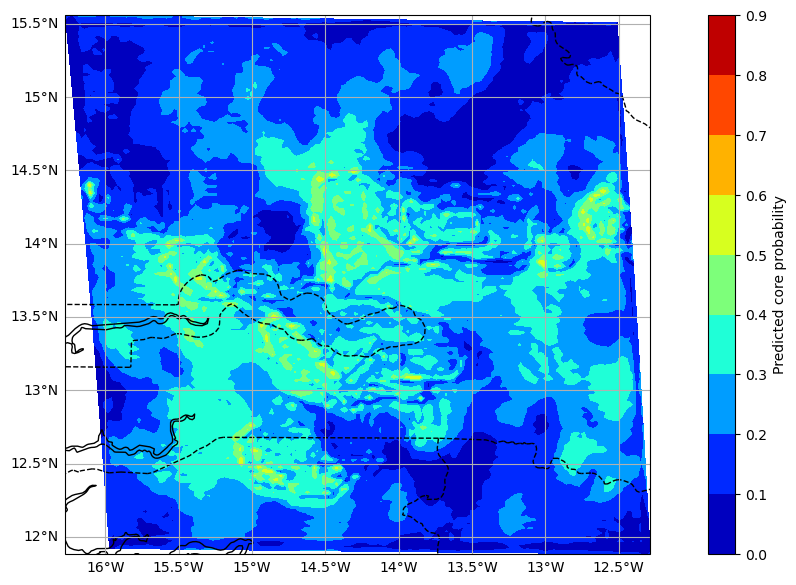

In [30]:
day = 0
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(pred_frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:], levels=np.arange(0,1,0.1), cbar_label='Predicted core probability', cmap='jet')
#draw_map(ax, np.squeeze(pred_frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


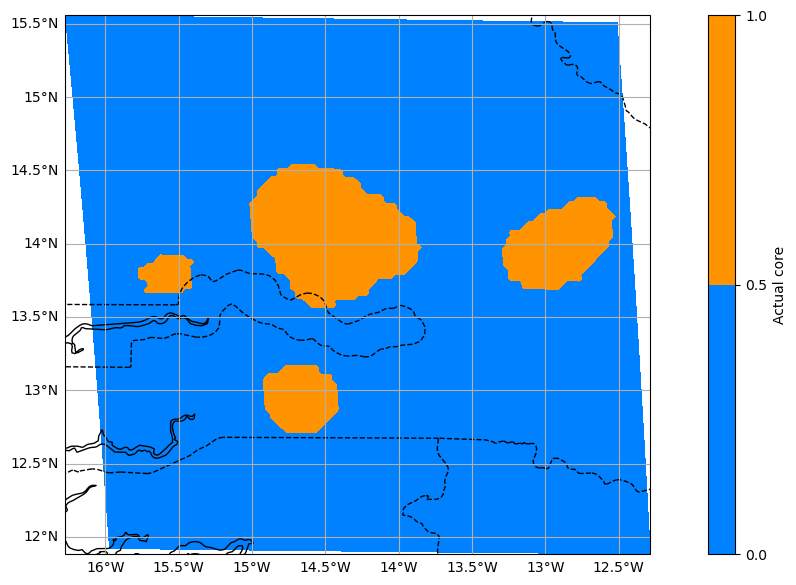

In [31]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[day,:,:]), lon[:-a,b:], lat[:-a,b:],levels=[0,.5,1], cbar_label='Actual core', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

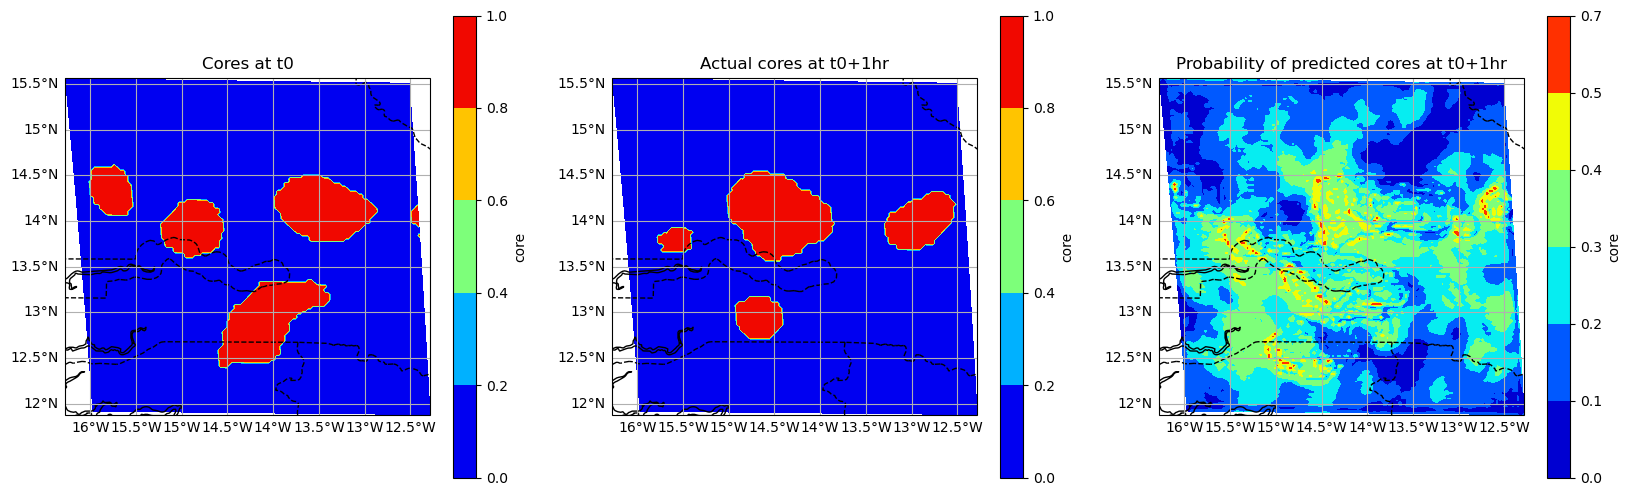

In [32]:
day = 3-2
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[0,:,:])
data[2] = np.squeeze(pred_frames[day-1,:,:,0])
titles = ['Cores at t0', 'Actual cores at t0+1hr', 'Probability of predicted cores at t0+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.1, 0.2, 0.3, 0.4,0.5,0.7]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[i],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

In [33]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [34]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 1hr


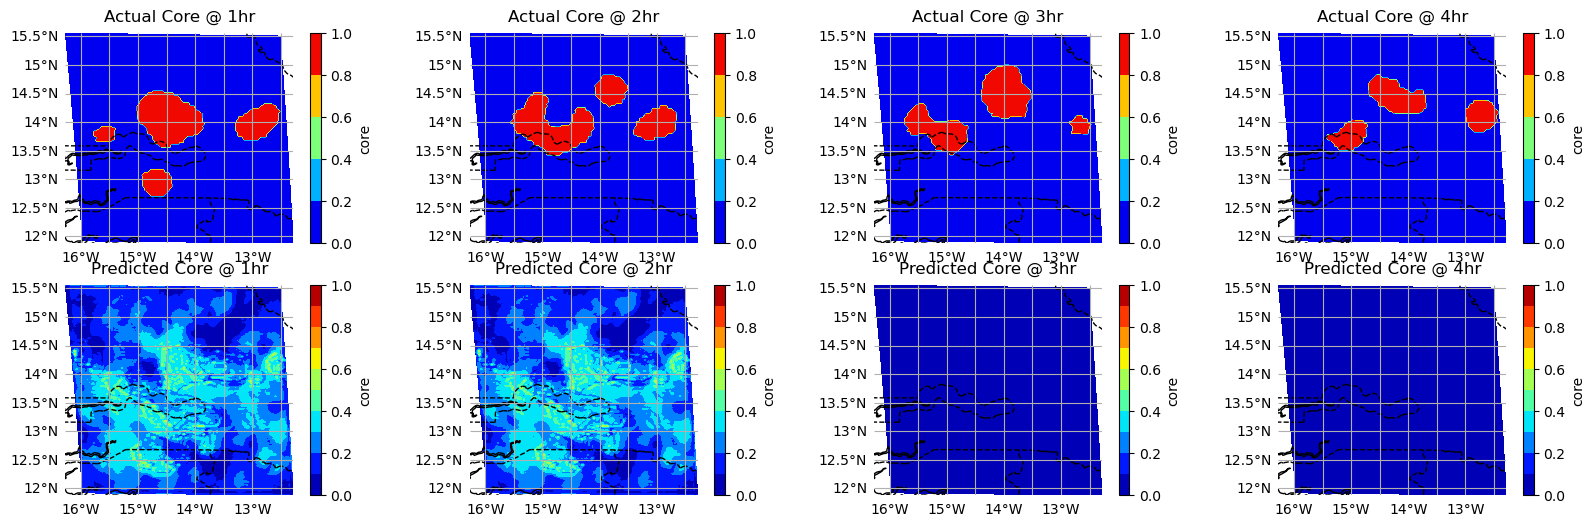

In [35]:
day = 6-2
data = np.zeros((day,image_height,image_width))
for x in range(0,2,1):
    data[x] = np.squeeze(pred_frames[x,:,:,0])
        
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.1,0.1)]  #[0, 0.1, 0.2, 0.3,0.4]]
#levels_custom=[[0, 0.5 ,1],[0, 0.5 ,1]]  #[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(original_frames[idx,:,:]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx + 1}hr")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= levels_custom[1])
    ax.set_title(f"Predicted Core @ {idx + 1}hr")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 1hr')
plt.show()